In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.stats import zscore
import os

# ---------------------------------------------------
# 0. Load dataset
# ---------------------------------------------------
FILE_PATH = "/kaggle/input/df-thesis/DF.csv"
df = pd.read_csv(FILE_PATH)
plot_dir = "/kaggle/working/MF_plots"
os.makedirs(plot_dir, exist_ok=True)
# ---------------------------------------------------
# 1. Filter out non-positive market values
# ---------------------------------------------------
df = df[df["MarketValue"] > 0].copy()

# ---------------------------------------------------
# 2. Log-transform MarketValue (optional)
# ---------------------------------------------------
df['LogMarketValue'] = np.log(df['MarketValue'])

# ---------------------------------------------------
# 3. Feature selection
# ---------------------------------------------------
selected_features = [
    'Overall rating', 'Potential', 'Dribbling', 'Stamina',
    'Shot power', 'Sprint speed', 'International reputation', 'team_score',
    'league_score', 'Age', 'Minutes', 'Yellow Cards', 'Heading accuracy',
    'Total defending', 'Blocks',
     'Starts','Interceptions','Interceptions_x','Wage','Defensive awareness',
    'Goals + Assists','Ball control','Value'
    ,'Tackles Won','Tkl+Int','Clearances','country_score','Aggression'

]
# ---------------------------------------------------
# 4. Prepare X and y
# ---------------------------------------------------
X = df[selected_features]
y = df['MarketValue']
value_feature = df['Value']  # we need it for the extra filtering

# ---------------------------------------------------
# 5. Handle missing values
# ---------------------------------------------------
X = X.fillna(X.median())

# ---------------------------------------------------
# 6. Outlier Removal
# ---------------------------------------------------
# Step 1: Z-Score based cleaning on MarketValue
z_scores = zscore(y)
threshold = 2.5  # tighter threshold

mask_zscore = np.abs(z_scores) < threshold

X = X[mask_zscore].reset_index(drop=True)
y = y[mask_zscore].reset_index(drop=True)
value_feature = value_feature[mask_zscore].reset_index(drop=True)

# Step 2: Value vs MarketValue logic-based cleaning
mask_value_vs_marketvalue = ~(
    ((y > 1.5 * value_feature) | (value_feature > 1.5 * y))
)


X_clean = X[mask_value_vs_marketvalue].reset_index(drop=True)
y_clean = y[mask_value_vs_marketvalue].reset_index(drop=True)
value_feature_clean = value_feature[mask_value_vs_marketvalue].reset_index(drop=True)

print(f"✅ After both outlier removals: {X_clean.shape[0]} samples remaining.")

# ---------------------------------------------------
# 7. Rebuild cleaned df
# ---------------------------------------------------
df_clean = X_clean.copy()
df_clean['MarketValue'] = y_clean
df_clean['Value'] = value_feature_clean

# ---------------------------------------------------
# 8. Define Segment boundaries (low, mid, high)
# ---------------------------------------------------
bins = [0, 1e6, 20e6, float("inf")]
labels = ["low", "mid", "high"]

df_clean["Segment"] = pd.cut(df_clean["MarketValue"], bins=bins, labels=labels)

# ---------------------------------------------------
# 9. Split into segments
# ---------------------------------------------------
df_low  = df_clean[df_clean["Segment"] == "low"].copy()
df_mid  = df_clean[df_clean["Segment"] == "mid"].copy()
df_high = df_clean[df_clean["Segment"] == "high"].copy()

print(f"Low segment:  {len(df_low)} players")
print(f"Mid segment:  {len(df_mid)} players")
print(f"High segment: {len(df_high)} players")
# ---------------------------------------------------
# 1. Split X and log(y) into train/test
# ---------------------------------------------------
X = df_clean[selected_features]
y_raw = df_clean['MarketValue'] 
X_train, X_test, y_train, y_test = train_test_split(
    X, y_raw, test_size=0.2, random_state=42
)
y_log = np.log(df_clean['MarketValue'])

X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

✅ After both outlier removals: 1225 samples remaining.
Low segment:  265 players
Mid segment:  883 players
High segment: 77 players


### 📊 XGBoost Model Performance (Fixed Params):
- MAE: 850694.764
- RMSE: 1639581.162
- R²: 0.962
- RMSPE: 25.988%

⚠️ Dropping corrupted/nested columns: []

📊 XGBoost Model Performance (Fixed Params):
MAE: 850694.764
RMSE: 1639581.162
R²: 0.962
RMSPE: 25.988%


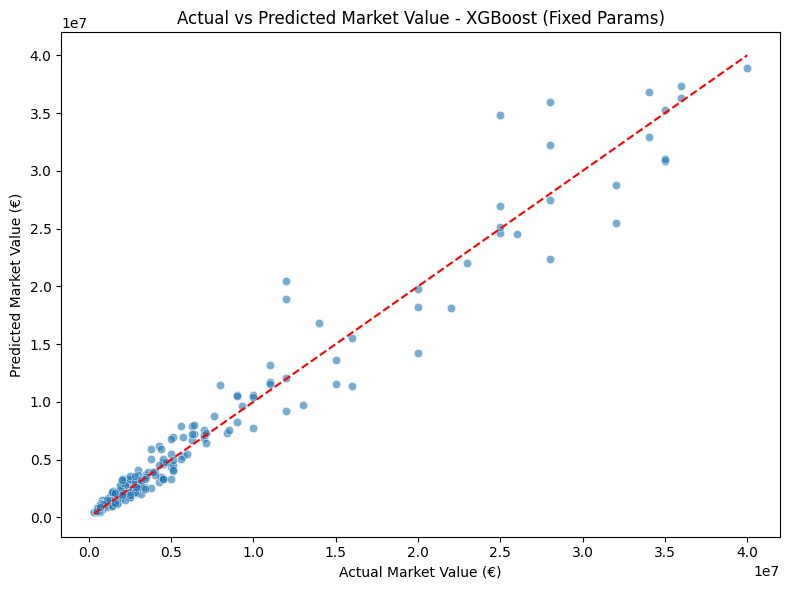

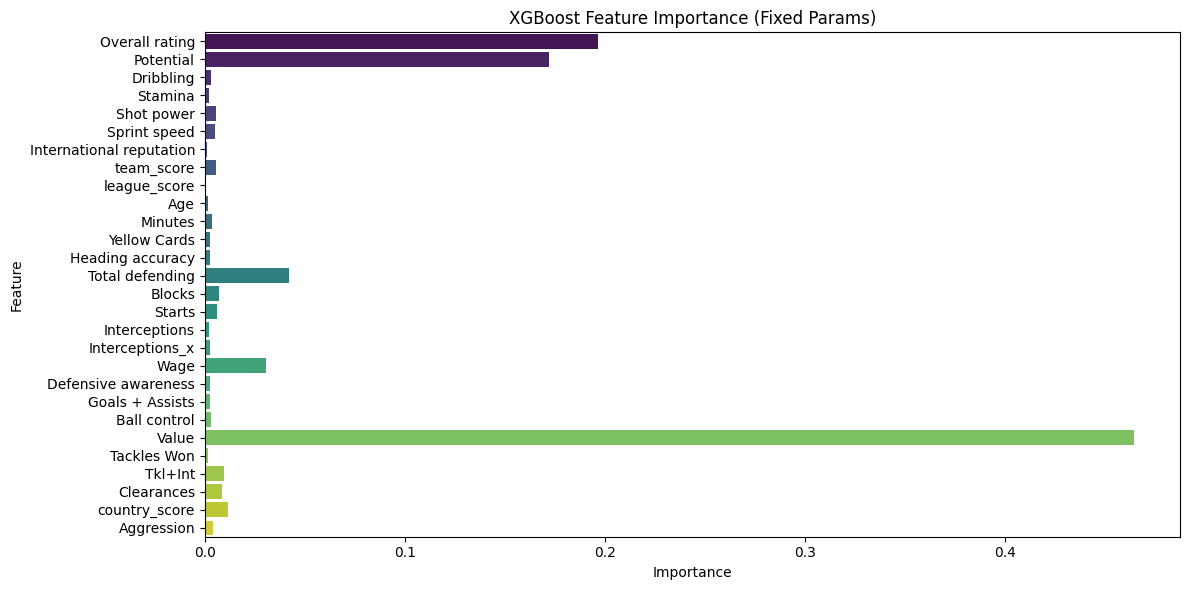

In [29]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pandas as pd


# ---------------------------------------------------
# 2. Drop corrupted/nested columns
# ---------------------------------------------------
def is_nested(obj):
    return isinstance(obj, (pd.Series, pd.DataFrame, list, dict))

corrupted_cols = [col for col in X_train.columns if isinstance(X_train[col].iloc[0], (pd.Series, pd.DataFrame, list, dict))]
print("⚠️ Dropping corrupted/nested columns:", corrupted_cols)

X_train_clean = X_train.drop(columns=corrupted_cols)
X_test_clean  = X_test.drop(columns=corrupted_cols)

# ---------------------------------------------------
# 3. Define and Train XGBoost with fixed parameters
# ---------------------------------------------------
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    colsample_bytree=0.7,
    learning_rate=0.05,
    max_depth=3,
    n_estimators=200,
    subsample=1.0
)
xgb_model.fit(X_train_clean, y_train)

# ---------------------------------------------------
# 4. Predict
# ---------------------------------------------------
y_pred = xgb_model.predict(X_test_clean)

# ---------------------------------------------------
# 5. Metrics functions
# ---------------------------------------------------
def rmspe(y_true, y_pred):
    pct_err = (y_true - y_pred) / y_true.replace(0, np.nan)
    return np.sqrt(np.nanmean(np.square(pct_err))) * 100

# ---------------------------------------------------
# 6. Evaluate
# ---------------------------------------------------
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
rmspe_val = rmspe(y_test.reset_index(drop=True), pd.Series(y_pred))

print("\n📊 XGBoost Model Performance (Fixed Params):")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")
print(f"RMSPE: {rmspe_val:.3f}%")

# ---------------------------------------------------
# 7. Plot: Actual vs Predicted
# ---------------------------------------------------
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'r--')
plt.xlabel("Actual Market Value (€)")
plt.ylabel("Predicted Market Value (€)")
plt.title("Actual vs Predicted Market Value - XGBoost (Fixed Params)")
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, "actual_vs_predicted_xgboost_fixed_params.png"))
plt.show()

# ---------------------------------------------------
# 8. Feature Importance
# ---------------------------------------------------
importances = xgb_model.feature_importances_

plt.figure(figsize=(12,6))
sns.barplot(x=importances, y=X_train_clean.columns, palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("XGBoost Feature Importance (Fixed Params)")
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, "feature_importance_xgboost_fixed_params.png"))
plt.show()


In [30]:
# ---------------------------------------------------
# Print Sample of Actual vs Predicted Market Values
# ---------------------------------------------------
sample_results = pd.DataFrame({
    'Actual Market Value (€)': y_test.values,
    'Predicted Market Value (€)': np.round(y_pred).astype(int)
})

# Show first 15 rows (you can adjust)
print("\n🧪 Sample of Actual vs Predicted Market Values:")
print(sample_results.head(15))



🧪 Sample of Actual vs Predicted Market Values:
    Actual Market Value (€)  Predicted Market Value (€)
0                   3400000                     2667006
1                   1100000                     1158011
2                   4500000                     3355128
3                  16000000                    15534881
4                   1000000                     1087967
5                    570000                      567868
6                   4500000                     4621595
7                    550000                      781037
8                    630000                      666713
9                   5000000                     4354938
10                 36000000                    37316380
11                  5700000                     5338118
12                  1900000                     2579769
13                  6300000                     7905916
14                  6300000                     6666638


### 📊 XGBoost Model Performance (LOG MarketValue):
- MAE (log): 0.183
- RMSE (log): 0.225
- R² (log): 0.962
- RMSPE (log): 1.553%

### 📊 XGBoost Model Performance (MarketValue € back-transformed):
- MAE (€): 847769.914
- RMSE (€): 1531520.051
- R² (€): 0.967
- RMSPE (€): 24.012%


⚠️ Dropping corrupted/nested columns: []

📊 XGBoost Model Performance (LOG MarketValue):
MAE (log): 0.183
RMSE (log): 0.225
R² (log): 0.962
RMSPE (log): 1.553%

📊 XGBoost Model Performance (MarketValue € back-transformed):
MAE (€): 847769.914
RMSE (€): 1531520.051
R² (€): 0.967
RMSPE (€): 24.012%


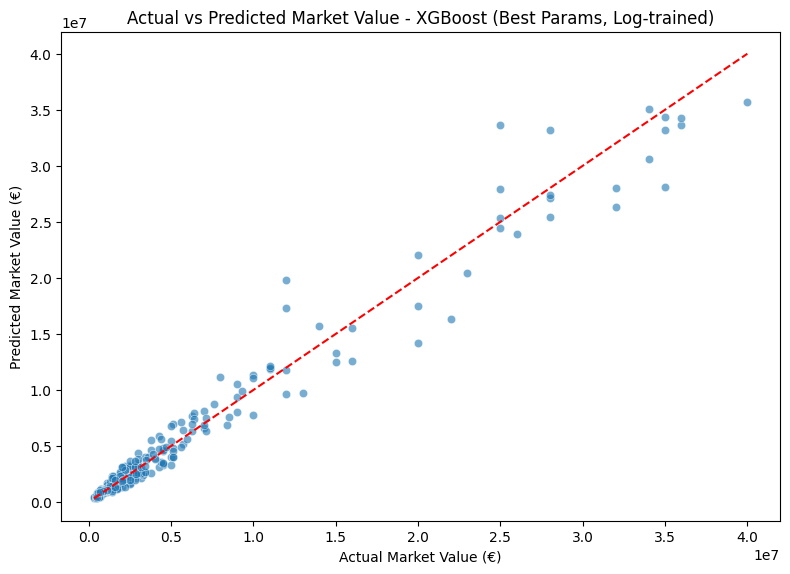

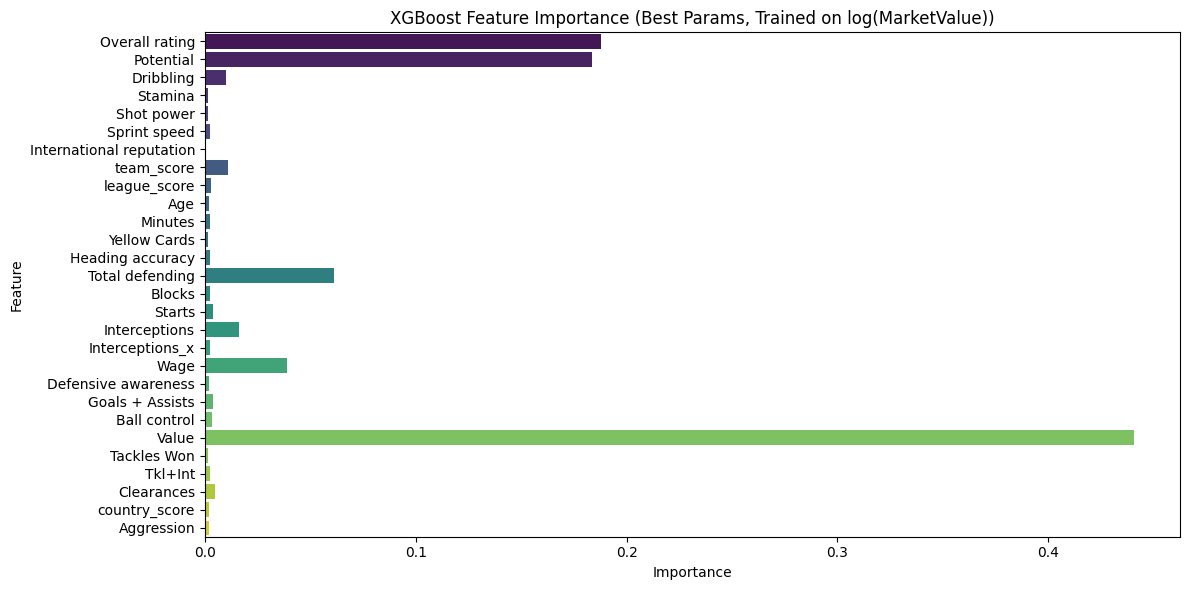

In [3]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pandas as pd

# ---------------------------------------------------
# 2. Drop corrupted/nested columns
# ---------------------------------------------------
def is_nested(obj):
    return isinstance(obj, (pd.Series, pd.DataFrame, list, dict))

corrupted_cols = [col for col in X_train.columns if is_nested(X_train[col].iloc[0])]
print("⚠️ Dropping corrupted/nested columns:", corrupted_cols)

X_train_clean = X_train.drop(columns=corrupted_cols)
X_test_clean  = X_test.drop(columns=corrupted_cols)

# ---------------------------------------------------
# 3. Define and Train XGBoost model (Best Parameters)
# ---------------------------------------------------
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    colsample_bytree=0.7,
    learning_rate=0.05,
    max_depth=3,
    n_estimators=200,
    subsample=1.0
)
xgb_model.fit(X_train_clean, y_train_log)

# ---------------------------------------------------
# 4. Predict
# ---------------------------------------------------
y_pred_log = xgb_model.predict(X_test_clean)

# ---------------------------------------------------
# 5. Metrics functions
# ---------------------------------------------------
def rmspe(y_true, y_pred):
    pct_err = (y_true - y_pred) / y_true.replace(0, np.nan)
    return np.sqrt(np.nanmean(np.square(pct_err))) * 100

# ---------------------------------------------------
# 6. Evaluate on log scale
# ---------------------------------------------------
mae_log = mean_absolute_error(y_test_log, y_pred_log)
mse_log = mean_squared_error(y_test_log, y_pred_log)
rmse_log = np.sqrt(mse_log)
r2_log = r2_score(y_test_log, y_pred_log)
rmspe_log = rmspe(y_test_log.reset_index(drop=True), pd.Series(y_pred_log))

print("\n📊 XGBoost Model Performance (LOG MarketValue):")
print(f"MAE (log): {mae_log:.3f}")
print(f"RMSE (log): {rmse_log:.3f}")
print(f"R² (log): {r2_log:.3f}")
print(f"RMSPE (log): {rmspe_log:.3f}%")

# ---------------------------------------------------
# 7. Back-transform predictions and evaluate on € scale
# ---------------------------------------------------
y_test_euros = np.exp(y_test_log)
y_pred_euros = np.exp(y_pred_log)

mae_euros = mean_absolute_error(y_test_euros, y_pred_euros)
mse_euros = mean_squared_error(y_test_euros, y_pred_euros)
rmse_euros = np.sqrt(mse_euros)
r2_euros = r2_score(y_test_euros, y_pred_euros)
rmspe_euros = rmspe(y_test_euros.reset_index(drop=True), pd.Series(y_pred_euros))

print("\n📊 XGBoost Model Performance (MarketValue € back-transformed):")
print(f"MAE (€): {mae_euros:.3f}")
print(f"RMSE (€): {rmse_euros:.3f}")
print(f"R² (€): {r2_euros:.3f}")
print(f"RMSPE (€): {rmspe_euros:.3f}%")

# ---------------------------------------------------
# 8. Plot: Actual vs Predicted (on raw €)
# ---------------------------------------------------
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test_euros, y=y_pred_euros, alpha=0.6)
lims = [min(y_test_euros.min(), y_pred_euros.min()), max(y_test_euros.max(), y_pred_euros.max())]
plt.plot(lims, lims, 'r--')
plt.xlabel("Actual Market Value (€)")
plt.ylabel("Predicted Market Value (€)")
plt.title("Actual vs Predicted Market Value - XGBoost (Best Params, Log-trained)")
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, "actual_vs_predicted_xgboost_best_params_logtrain.png"))
plt.show()

# ---------------------------------------------------
# 9. Feature Importance
# ---------------------------------------------------
importances = xgb_model.feature_importances_

plt.figure(figsize=(12,6))
sns.barplot(x=importances, y=X_train_clean.columns, palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("XGBoost Feature Importance (Best Params, Trained on log(MarketValue))")
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, "feature_importance_xgboost_best_params_logtrain.png"))
plt.show()


In [7]:
import pandas as pd
import numpy as np

# Use RMSPE in real MarketValue scale
rmspe_percent = 24.01  # in percent
rmspe_decimal = rmspe_percent / 100

# Re-read the original file to recover player names
original_df = pd.read_csv("/kaggle/input/df-thesis/DF.csv")

# Merge names back using MarketValue and Value as keys (or add an ID column in preprocessing)
df_clean_with_names = df_clean.merge(
    original_df[['Name', 'MarketValue', 'Value']],
    on=['MarketValue', 'Value'],  # you can also use an ID if available
    how='left'
)

# Sample 5 diverse players
sample_df = pd.concat([
    df_clean_with_names[df_clean_with_names['MarketValue'] < 1e6].sample(1),
    df_clean_with_names[(df_clean_with_names['MarketValue'] >= 1e6) & (df_clean_with_names['MarketValue'] < 2e7)].sample(1),
    df_clean_with_names[df_clean_with_names['MarketValue'] >= 2e7].sample(1),
    df_clean_with_names[df_clean_with_names['MarketValue'] < df_clean_with_names['MarketValue'].median()].sample(1),
    df_clean_with_names[df_clean_with_names['MarketValue'] > df_clean_with_names['MarketValue'].median()].sample(1)
], ignore_index=True)

# Extract features and player names
sample_X = sample_df[selected_features]
player_names = sample_df['Name'].fillna('Unknown')
actual_values = sample_df['MarketValue'].values

# Predict in log scale → convert to €
log_preds = xgb_model.predict(sample_X)
predicted_values = np.exp(log_preds)

# Confidence intervals
lower_bounds = predicted_values * (1 - rmspe_decimal)
upper_bounds = predicted_values * (1 + rmspe_decimal)

# Final prediction table
results_df = pd.DataFrame({
    'Player': player_names,
    'Actual (€)': actual_values.astype(int),
    'Predicted (€)': predicted_values.astype(int),
    'Lower Bound (€)': lower_bounds.astype(int),
    'Upper Bound (€)': upper_bounds.astype(int)
})

# Display
print(f"\n🎯 Predicted Market Values with 90% Confidence Intervals (RMSPE = {rmspe_percent}%):")
print(results_df.to_string(index=False))



🎯 Predicted Market Values with 90% Confidence Intervals (RMSPE = 24.01%):
     Player  Actual (€)  Predicted (€)  Lower Bound (€)  Upper Bound (€)
 K. Coronel      450000         515886           392022           639750
   O. Kabak    11000000        9279018          7051125         11506910
 M. Dembélé    28000000       27142246         20625392         33659100
M. Tambedou     1100000        1089971           828269          1351673
  J. Storey     2100000        2199082          1671082          2727082


### 📊 Random Forest Model Performance (Fixed Best Parameters):
- MAE (€): 945412.159
- RMSE (€): 1755158.617
- R²: 0.956
- RMSPE: 26.368%

⚠️ Dropping corrupted/nested columns: []

📊 Random Forest Model Performance (Fixed Best Parameters):
MAE (€): 945412.159
RMSE (€): 1755158.617
R²: 0.956
RMSPE: 26.368%


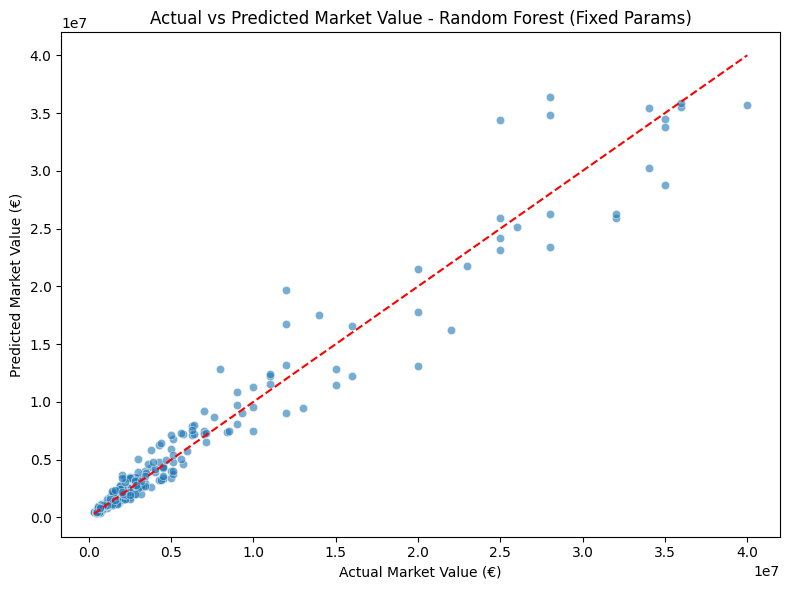

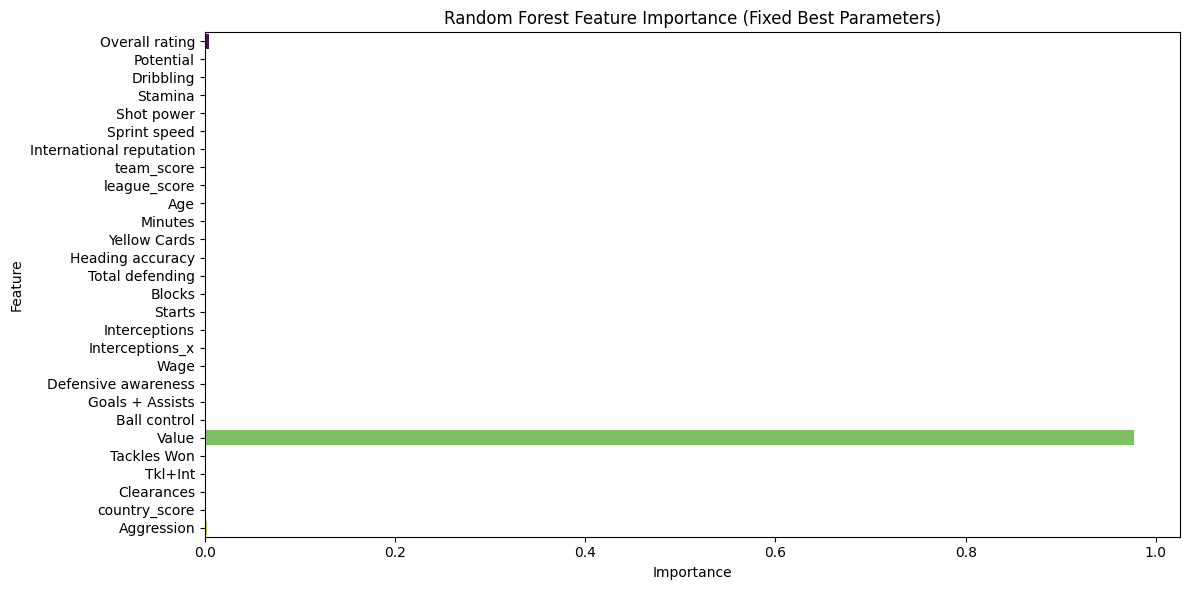

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pandas as pd

# ---------------------------------------------------
# 2. Drop corrupted/nested columns
# ---------------------------------------------------
def is_nested(obj):
    return isinstance(obj, (pd.Series, pd.DataFrame, list, dict))

corrupted_cols = [col for col in X_train.columns if is_nested(X_train[col].iloc[0])]
print("⚠️ Dropping corrupted/nested columns:", corrupted_cols)

X_train_clean = X_train.drop(columns=corrupted_cols)
X_test_clean  = X_test.drop(columns=corrupted_cols)

# ---------------------------------------------------
# 3. Define and Train Random Forest (Fixed Best Parameters)
# ---------------------------------------------------
rf_model = RandomForestRegressor(
    random_state=42,
    max_depth=10,
    max_features=None,
    min_samples_leaf=5,
    min_samples_split=2,
    n_estimators=100
)
rf_model.fit(X_train_clean, y_train)

# ---------------------------------------------------
# 4. Predict
# ---------------------------------------------------
y_pred = rf_model.predict(X_test_clean)

# ---------------------------------------------------
# 5. Metrics functions
# ---------------------------------------------------
def rmspe(y_true, y_pred):
    pct_err = (y_true - y_pred) / y_true.replace(0, np.nan)
    return np.sqrt(np.nanmean(np.square(pct_err))) * 100

# ---------------------------------------------------
# 6. Evaluate
# ---------------------------------------------------
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
rmspe_val = rmspe(y_test.reset_index(drop=True), pd.Series(y_pred))

print("\n📊 Random Forest Model Performance (Fixed Best Parameters):")
print(f"MAE (€): {mae:.3f}")
print(f"RMSE (€): {rmse:.3f}")
print(f"R²: {r2:.3f}")
print(f"RMSPE: {rmspe_val:.3f}%")

# ---------------------------------------------------
# 7. Plot: Actual vs Predicted
# ---------------------------------------------------
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'r--')
plt.xlabel("Actual Market Value (€)")
plt.ylabel("Predicted Market Value (€)")
plt.title("Actual vs Predicted Market Value - Random Forest (Fixed Params)")
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, "actual_vs_predicted_rf_fixed_params.png"))
plt.show()

# ---------------------------------------------------
# 8. Feature Importance
# ---------------------------------------------------
importances = rf_model.feature_importances_

plt.figure(figsize=(12,6))
sns.barplot(x=importances, y=X_train_clean.columns, palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importance (Fixed Best Parameters)")
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, "feature_importance_rf_fixed_params.png"))
plt.show()



### 📊 Random Forest Model Performance (LOG MarketValue):
- MAE (log): 0.193
- RMSE (log): 0.234
- R² (log): 0.959
- RMSPE (log): 1.609%

### 📊 Random Forest Model Performance (MarketValue € back-transformed):
- MAE (€): 948821.742
- RMSE (€): 1796933.355
- R² (€): 0.954
- RMSPE (€): 24.885%


📊 Random Forest Model Performance (LOG MarketValue):
MAE (log): 0.193
RMSE (log): 0.234
R² (log): 0.959
RMSPE (log): 1.609%

📊 Random Forest Model Performance (MarketValue € back-transformed):
MAE (€): 948821.742
RMSE (€): 1796933.355
R² (€): 0.954
RMSPE (€): 24.885%


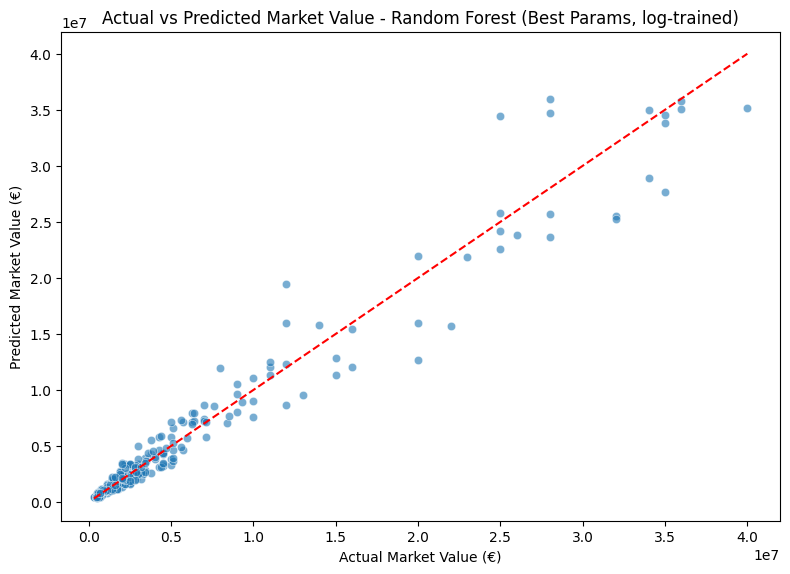

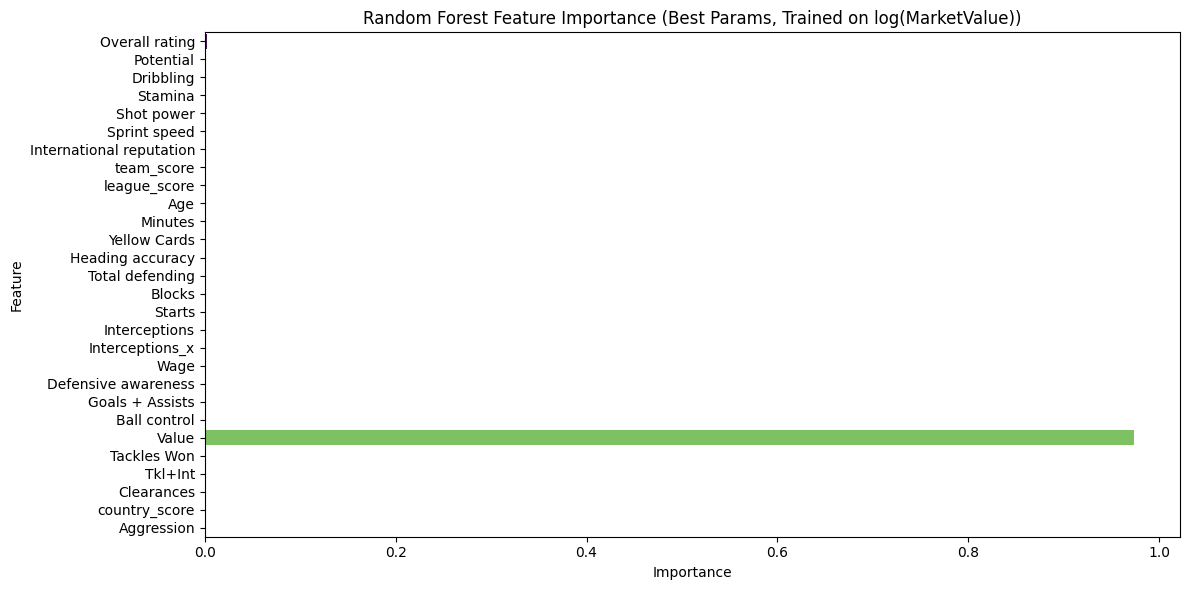

In [33]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pandas as pd

# ---------------------------------------------------
# 0. Make sure plot directory exists
# ---------------------------------------------------



# ---------------------------------------------------
# 3. Define and Train Random Forest (Best Fixed Parameters)
# ---------------------------------------------------
rf_model = RandomForestRegressor(
    random_state=42,
    max_depth=10,
    max_features=None,
    min_samples_leaf=5,
    min_samples_split=2,
    n_estimators=300
)
rf_model.fit(X_train_clean, y_train_log)

# ---------------------------------------------------
# 4. Predict
# ---------------------------------------------------
y_pred_log = rf_model.predict(X_test_clean)

# ---------------------------------------------------
# 5. Metrics helpers
# ---------------------------------------------------
def rmspe(y_true, y_pred):
    pct_err = (y_true - y_pred) / y_true.replace(0, np.nan)
    return np.sqrt(np.nanmean(np.square(pct_err))) * 100

# ---------------------------------------------------
# 6. Evaluate on log scale
# ---------------------------------------------------
mae_log = mean_absolute_error(y_test_log, y_pred_log)
mse_log = mean_squared_error(y_test_log, y_pred_log)
rmse_log = np.sqrt(mse_log)
r2_log = r2_score(y_test_log, y_pred_log)
rmspe_log = rmspe(y_test_log.reset_index(drop=True), pd.Series(y_pred_log))

print("\n📊 Random Forest Model Performance (LOG MarketValue):")
print(f"MAE (log): {mae_log:.3f}")
print(f"RMSE (log): {rmse_log:.3f}")
print(f"R² (log): {r2_log:.3f}")
print(f"RMSPE (log): {rmspe_log:.3f}%")

# ---------------------------------------------------
# 7. Back-transform predictions and evaluate on € scale
# ---------------------------------------------------
y_test_euros = np.exp(y_test_log)
y_pred_euros = np.exp(y_pred_log)

mae_euros = mean_absolute_error(y_test_euros, y_pred_euros)
mse_euros = mean_squared_error(y_test_euros, y_pred_euros)
rmse_euros = np.sqrt(mse_euros)
r2_euros = r2_score(y_test_euros, y_pred_euros)
rmspe_euros = rmspe(y_test_euros.reset_index(drop=True), pd.Series(y_pred_euros))

print("\n📊 Random Forest Model Performance (MarketValue € back-transformed):")
print(f"MAE (€): {mae_euros:.3f}")
print(f"RMSE (€): {rmse_euros:.3f}")
print(f"R² (€): {r2_euros:.3f}")
print(f"RMSPE (€): {rmspe_euros:.3f}%")

# ---------------------------------------------------
# 8. Plot: Actual vs Predicted (€ scale)
# ---------------------------------------------------
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test_euros, y=y_pred_euros, alpha=0.6)
lims = [min(y_test_euros.min(), y_pred_euros.min()), max(y_test_euros.max(), y_pred_euros.max())]
plt.plot(lims, lims, 'r--')
plt.xlabel("Actual Market Value (€)")
plt.ylabel("Predicted Market Value (€)")
plt.title("Actual vs Predicted Market Value - Random Forest (Best Params, log-trained)")
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, "actual_vs_predicted_rf_best_params_logtrain.png"))
plt.show()

# ---------------------------------------------------
# 9. Feature Importance
# ---------------------------------------------------
importances = rf_model.feature_importances_

plt.figure(figsize=(12,6))
sns.barplot(x=importances, y=X_train_clean.columns, palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importance (Best Params, Trained on log(MarketValue))")
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, "feature_importance_rf_best_params_logtrain.png"))
plt.show()


### 📊 Best Stacked Model Performance (Normal MarketValue €):
- MAE (€): 898,630
- RMSE (€): 1,668,106
- R²: 0.960
- RMSPE (€): 24.48%


📊 Best Stacked Model Performance (Normal MarketValue €):
MAE (€): 898,630
RMSE (€): 1,668,106
R²: 0.960
RMSPE (€): 24.48%


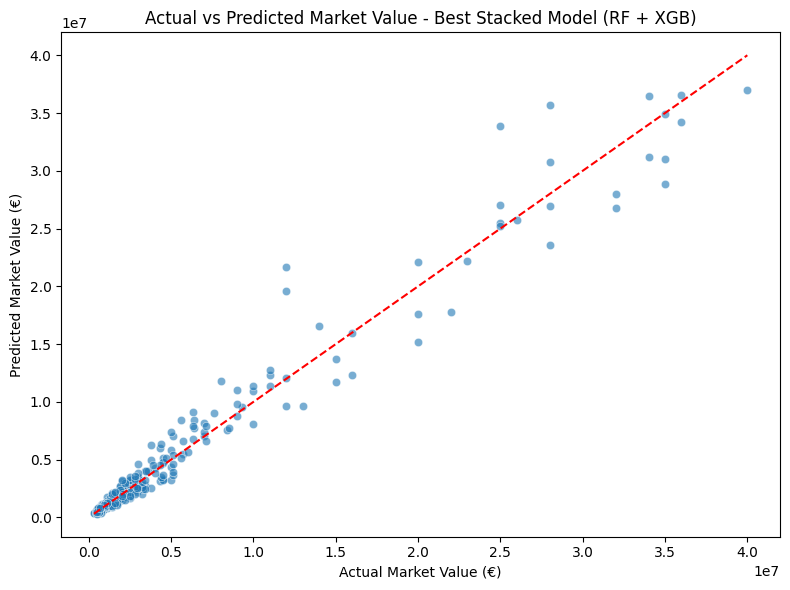

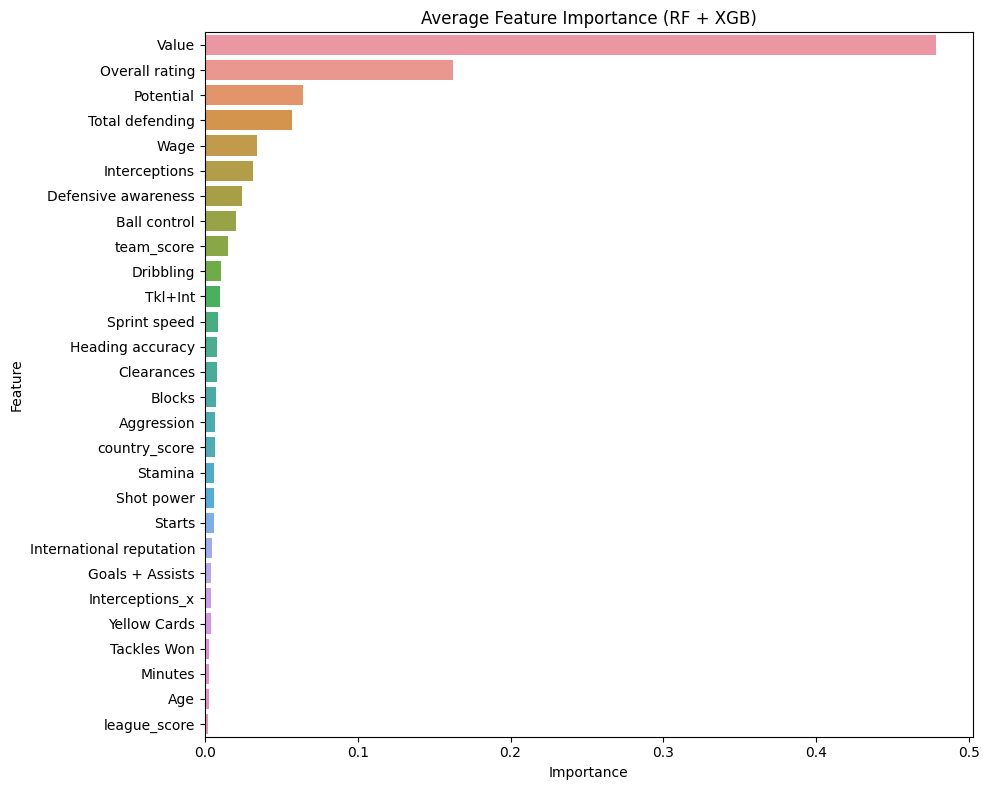

In [34]:
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pandas as pd

# ---------------------------------------------------
# 0. Make sure plot directory exists
# ---------------------------------------------------
plot_dir = "/kaggle/working/MF_plots"
os.makedirs(plot_dir, exist_ok=True)

# ---------------------------------------------------
# 1. Prepare Data (X and y for normal MarketValue)
# ---------------------------------------------------
X = df_clean[selected_features]
y = df_clean['MarketValue']  # normal €

# ---------------------------------------------------
# 2. Split into Train and Test sets
# ---------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ---------------------------------------------------
# 3. Remove corrupted/nested columns
# ---------------------------------------------------
def is_nested(obj):
    return isinstance(obj, (pd.Series, pd.DataFrame, list, dict))

corrupted_cols = [col for col in X_train.columns if is_nested(X_train[col].iloc[0])]
X_train_clean = X_train.drop(columns=corrupted_cols)
X_test_clean  = X_test.drop(columns=corrupted_cols)

# ---------------------------------------------------
# 4. Define Base Models with Best Params
# ---------------------------------------------------
rf_model = RandomForestRegressor(
    random_state=42,
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200
)

xgb_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    colsample_bytree=0.9,
    learning_rate=0.05,
    max_depth=3,
    n_estimators=200,
    subsample=1
)

# ---------------------------------------------------
# 5. Create Stacked Model
# ---------------------------------------------------
stacked_model = StackingRegressor(
    estimators=[
        ('rf', rf_model),
        ('xgb', xgb_model)
    ],
    final_estimator=make_pipeline(
        StandardScaler(),
        RidgeCV()
    ),
    n_jobs=-1
)

# ---------------------------------------------------
# 6. Train Stacked Model
# ---------------------------------------------------
stacked_model.fit(X_train_clean, y_train)

# ---------------------------------------------------
# 7. Predict
# ---------------------------------------------------
y_pred = stacked_model.predict(X_test_clean)

# ---------------------------------------------------
# 8. Define Metrics Helpers
# ---------------------------------------------------
def rmspe(y_true, y_pred):
    pct_err = (y_true - y_pred) / y_true.replace(0, np.nan)
    return np.sqrt(np.nanmean(np.square(pct_err))) * 100

# ---------------------------------------------------
# 9. Evaluate
# ---------------------------------------------------
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
rmspe_val = rmspe(y_test.reset_index(drop=True), pd.Series(y_pred))

print("\n📊 Best Stacked Model Performance (Normal MarketValue €):")
print(f"MAE (€): {mae:,.0f}")
print(f"RMSE (€): {rmse:,.0f}")
print(f"R²: {r2:.3f}")
print(f"RMSPE (€): {rmspe_val:.2f}%")

# ---------------------------------------------------
# 10. Plot: Actual vs Predicted
# ---------------------------------------------------
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'r--')
plt.xlabel("Actual Market Value (€)")
plt.ylabel("Predicted Market Value (€)")
plt.title("Actual vs Predicted Market Value - Best Stacked Model (RF + XGB)")
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, "stacked_actual_vs_predicted_best_params.png"))
plt.show()

# ---------------------------------------------------
# 11. Plot Feature Importances
# ---------------------------------------------------
# Since feature importance is not defined for RidgeCV (only trees),
# we can average RF and XGB importances:
# ---------------------------------------------------
# 11. Plot Feature Importances (correctly from fitted models inside stacking)
# ---------------------------------------------------

# Access the fitted models
fitted_rf = stacked_model.named_estimators_['rf']
fitted_xgb = stacked_model.named_estimators_['xgb']

# Get importances
rf_importances = fitted_rf.feature_importances_
xgb_importances = fitted_xgb.feature_importances_

# Average them
avg_importances = (rf_importances + xgb_importances) / 2

# Create dataframe
feature_importances_df = pd.DataFrame({
    'Feature': X_train_clean.columns,
    'Importance': avg_importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10,8))
sns.barplot(data=feature_importances_df, y='Feature', x='Importance')
plt.title("Average Feature Importance (RF + XGB)")
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, "stacked_feature_importance_best_params_fixed.png"))
plt.show()



### 📊 Final Stacked Model Performance (LOG MarketValue):
- MAE (log): 0.184
- RMSE (log): 0.226
- R² (log): 0.962
- RMSPE (log): 1.56%

### 📊 Final Stacked Model Performance (MarketValue € back-transformed):
- MAE (€): 854,658
- RMSE (€): 1,583,783
- R² (€): 0.964
- RMSPE (€): 23.95%

✅ Data Split Done: X_train: (980, 28), X_test: (245, 28)

📊 Final Stacked Model Performance (LOG MarketValue):
MAE (log): 0.184
RMSE (log): 0.226
R² (log): 0.962
RMSPE (log): 1.56%

📊 Final Stacked Model Performance (MarketValue € back-transformed):
MAE (€): 854,658
RMSE (€): 1,583,783
R² (€): 0.964
RMSPE (€): 23.95%


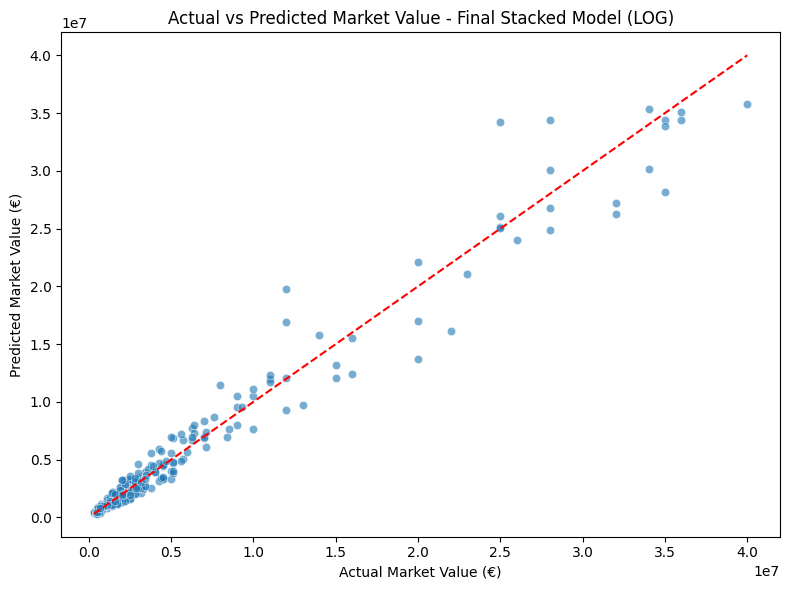

In [35]:
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pandas as pd

# ---------------------------------------------------
# 0. Make sure plot directory exists
# ---------------------------------------------------
plot_dir = "/kaggle/working/MF_plots"
os.makedirs(plot_dir, exist_ok=True)

# ---------------------------------------------------
# 1. Prepare Data (X and log(y))
# ---------------------------------------------------
X = df_clean[selected_features]
y = df_clean['MarketValue']  # normal €

# Transform target to log
y_log = np.log(y)

# ---------------------------------------------------
# 2. Split into Train and Test sets
# ---------------------------------------------------
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

print(f"✅ Data Split Done: X_train: {X_train.shape}, X_test: {X_test.shape}")

# ---------------------------------------------------
# 3. Remove corrupted/nested columns
# ---------------------------------------------------
def is_nested(obj):
    return isinstance(obj, (pd.Series, pd.DataFrame, list, dict))

corrupted_cols = [col for col in X_train.columns if is_nested(X_train[col].iloc[0])]
X_train_clean = X_train.drop(columns=corrupted_cols)
X_test_clean  = X_test.drop(columns=corrupted_cols)

# ---------------------------------------------------
# 4. Define Base Models with Best Params
# ---------------------------------------------------
rf_model = RandomForestRegressor(
    random_state=42,
    max_depth=10,
    max_features=None,
    min_samples_leaf=5,
    min_samples_split=2,
    n_estimators=300
)

xgb_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    colsample_bytree=0.7,
    learning_rate=0.05,
    max_depth=3,
    n_estimators=200,
    subsample=1.0
)

# ---------------------------------------------------
# 5. Create Stacked Model
# ---------------------------------------------------
stacked_model = StackingRegressor(
    estimators=[
        ('rf', rf_model),
        ('xgb', xgb_model)
    ],
    final_estimator=make_pipeline(
        StandardScaler(),
        RidgeCV()
    ),
    n_jobs=-1
)

# ---------------------------------------------------
# 6. Train Stacked Model
# ---------------------------------------------------
stacked_model.fit(X_train_clean, y_train_log)

# ---------------------------------------------------
# 7. Predict
# ---------------------------------------------------
y_pred_log = stacked_model.predict(X_test_clean)

# Back-transform predictions
y_pred_euros = np.exp(y_pred_log)
y_test_euros = np.exp(y_test_log)

# ---------------------------------------------------
# 8. Define Metrics Helpers
# ---------------------------------------------------
def rmspe(y_true, y_pred):
    pct_err = (y_true - y_pred) / y_true.replace(0, np.nan)
    return np.sqrt(np.nanmean(np.square(pct_err))) * 100

# ---------------------------------------------------
# 9. Evaluate
# ---------------------------------------------------
print("\n📊 Final Stacked Model Performance (LOG MarketValue):")
print(f"MAE (log): {mean_absolute_error(y_test_log, y_pred_log):.3f}")
print(f"RMSE (log): {np.sqrt(mean_squared_error(y_test_log, y_pred_log)):.3f}")
print(f"R² (log): {r2_score(y_test_log, y_pred_log):.3f}")
print(f"RMSPE (log): {rmspe(y_test_log.reset_index(drop=True), pd.Series(y_pred_log)):.2f}%")

print("\n📊 Final Stacked Model Performance (MarketValue € back-transformed):")
print(f"MAE (€): {mean_absolute_error(y_test_euros, y_pred_euros):,.0f}")
print(f"RMSE (€): {np.sqrt(mean_squared_error(y_test_euros, y_pred_euros)):,.0f}")
print(f"R² (€): {r2_score(y_test_euros, y_pred_euros):.3f}")
print(f"RMSPE (€): {rmspe(y_test_euros.reset_index(drop=True), pd.Series(y_pred_euros)):.2f}%")

# ---------------------------------------------------
# 10. Plot: Actual vs Predicted (MarketValue €)
# ---------------------------------------------------
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test_euros, y=y_pred_euros, alpha=0.6)
lims = [min(y_test_euros.min(), y_pred_euros.min()), max(y_test_euros.max(), y_pred_euros.max())]
plt.plot(lims, lims, 'r--')
plt.xlabel("Actual Market Value (€)")
plt.ylabel("Predicted Market Value (€)")
plt.title("Actual vs Predicted Market Value - Final Stacked Model (LOG)")
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, "stacked_actual_vs_predicted_final_log.png"))
plt.show()


In [36]:
# ---------------------------------------------------
# 11. Build Prediction Intervals (90% Confidence)
# ---------------------------------------------------
# Define 85% confidence Z score
Z = 1.44  # for ~85% confidence

# RMSPE in percentage
rmspe_percent = 22.5  # from your model performance
rmspe_ratio = rmspe_percent / 100

# Calculate lower and upper bounds
lower_bound = y_pred_euros * (1 - Z * rmspe_ratio)
upper_bound = y_pred_euros * (1 + Z * rmspe_ratio)

# Clip lower bounds to avoid negative MarketValues
lower_bound = np.clip(lower_bound, 0, None)

# Create a dataframe for easy viewing
predicted_intervals_df = pd.DataFrame({
    'Actual (€)': y_test_euros.values.astype(int),
    'Predicted (€)': y_pred_euros.astype(int),
    'Lower Bound (€)': lower_bound.astype(int),
    'Upper Bound (€)': upper_bound.astype(int)
})

# Show first 10 results
print("\n🧠 Predicted Market Values with 90% Prediction Intervals:")
print(predicted_intervals_df.head(10))



🧠 Predicted Market Values with 90% Prediction Intervals:
   Actual (€)  Predicted (€)  Lower Bound (€)  Upper Bound (€)
0     3399999        2758604          1864816          3652392
1     1100000        1173831           793510          1554153
2     4500000        3292102          2225461          4358744
3    15999999       15565994         10522612         20609376
4      999999        1065528           720297          1410760
5      570000         509258           344258           674258
6     4500000        4631015          3130566          6131464
7      550000         646896           437302           856491
8      629999         615042           415768           814316
9     5000000        3987000          2695212          5278789
